### Modelo de regresión precios de vehiculos usados

 Crear un modelo de regresión para predecir el precio de un vehículo usado.

#### Librerias

In [1]:
import pandas as pd
import numpy as np 
import math
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Wrangling

In [2]:
vehicle_prices = pd.read_csv("vehicle_prices.csv")

In [126]:
vehicle_prices.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145.0,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145.0,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30.0,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145.0,43.5,1.4,vauxhall


#####  Checking null values

In [4]:
samples = vehicle_prices.shape[0]
keep_cols = []
drop_cols = []

for col in vehicle_prices.columns:
    nas = vehicle_prices[col].isna().sum()
    percent = round(100*nas/samples,2)
    if nas > 0:
        print('{0:<20} {1:<20} {2}%'.format(col,nas,percent))
    if percent < 30:
        keep_cols.append(col)
    else:
        drop_cols.append(col)

tax                  9353                 8.62%
mpg                  9353                 8.62%


Aquí podemos notar que las únicas 2 columnas que tienen valores nulos son la columna tax y mpg, al ser pocos datos nulos no voy a eliminar las columnas si no que voy a realizar algun tipo de imputación, ya sea la *media* o *mediana*


##### Cheking dataset variable types

In [5]:
num_features = vehicle_prices.select_dtypes(include='number').columns
cat_features = vehicle_prices.select_dtypes(exclude='number').columns

print('Numerical Features:')
for f in num_features:
    print(f,end=', ')

print('\n\nCategorical Features:')
for f in cat_features:
    print(f,end=', ')

Numerical Features:
year, price, mileage, tax, mpg, engineSize, 

Categorical Features:
model, transmission, fuelType, make, 

Aqui podemos ver la división de los tipos de dato que tenemos

<AxesSubplot:>

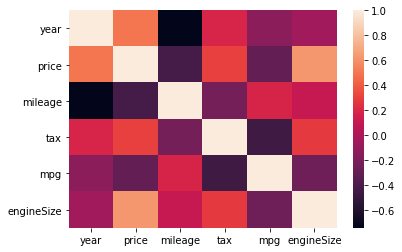

In [6]:
correlation_0 = vehicle_prices.corr()
sn.heatmap(correlation_0, xticklabels = correlation_0.columns, yticklabels=correlation_0.columns)

##### Cheking categorical values

In [7]:
vehicle_prices.transmission.value_counts()

Manual       61308
Semi-Auto    24903
Automatic    22319
Other           10
Name: transmission, dtype: int64

Podemos ver que el tipo de transmisión *other* tiene solamente 10 observaciones, por lo cual vamos a quitarla.

In [8]:
vehicle_prices.fuelType.value_counts()

Petrol      59875
Diesel      45177
Hybrid       3229
Other         253
Electric        6
Name: fuelType, dtype: int64

Al igual que con el tipo de transmisión , podemos ver que el tipo de carro *eléctrico* y *other* no representan datos sifnificativos , por lo cual vamos a quitarlos

In [9]:
vehicle_prices.make.value_counts()

ford        23419
mercedes    17018
vw          15157
vauxhall    13632
bmw         10781
audi        10668
toyota       6738
skoda        6267
hyundai      4860
Name: make, dtype: int64

La variable **make** es donde encontramos las marcas del vehículo y todas las marcas representan valores significativos por lo cual no voy a quitar ninguno

In [10]:
vehicle_prices.model.value_counts()

Focus              10042
C Class             7646
Fiesta              6557
Golf                4863
Corsa               3441
                   ...  
180                    1
220                    1
Transit Tourneo        1
Accent                 1
Amica                  1
Name: model, Length: 195, dtype: int64

Esta variable la voy a botar para el análisis, ya que representa con demasiados modelos de los carros y mi análisis será sobre la marca del vehículo

##### Checking numerical values

In [11]:
vehicle_prices.year.value_counts()

2019    29955
2017    23686
2016    16948
2018    15092
2015     8359
2020     4657
2014     4377
2013     2818
2012      702
2011      477
2010      369
2009      321
2008      233
2007      185
2006       92
2005       84
2004       55
2003       39
2002       36
2001       20
2000        9
1998        9
1999        6
1997        4
1970        2
1996        2
1995        1
2060        1
1991        1
Name: year, dtype: int64

In [12]:
years_ = vehicle_prices[vehicle_prices['year'] > 2012]  

Voy a elegir solo los años arriba del 2012 ya que solo estos tienen valores significativos

In [13]:
years_.year.unique()

array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020, 2060], dtype=int64)

<AxesSubplot:xlabel='year', ylabel='count'>

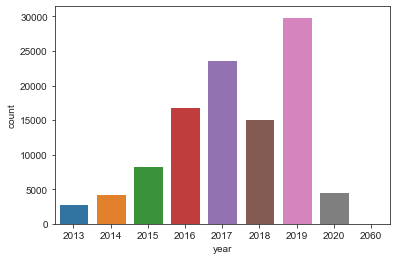

In [14]:

sn.set_style('ticks')
sn.countplot(x='year', data = years_)

Elegimos usar los datos a partir del 2012 ya que solamente estos son significativos y cuentan con más de 1,000 observaciones, así mismo podemos ver que existe 1 dato en el año 2060, por lo cual vamos a quitarlo

<AxesSubplot:xlabel='mileage', ylabel='Density'>

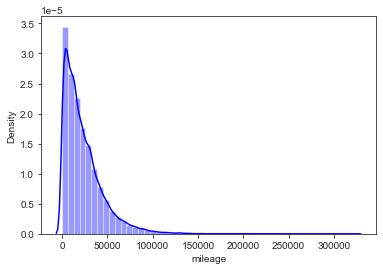

In [15]:
sn.distplot(vehicle_prices.mileage, color='blue')

Al ver esta gráfica podemos ver que la data no está distribuida de manera normal, por lo cual que normalizarla

<AxesSubplot:xlabel='tax', ylabel='Density'>

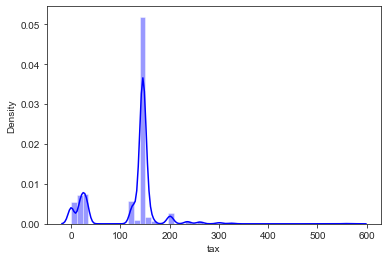

In [16]:
sn.distplot(vehicle_prices.tax,color='blue')

Hay que normalizar este dato también

<AxesSubplot:xlabel='tax', ylabel='Density'>

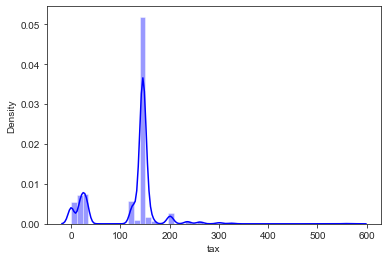

In [17]:
sn.distplot(vehicle_prices.tax ,color='blue')

Dato a normalizar

<AxesSubplot:xlabel='mpg', ylabel='Density'>

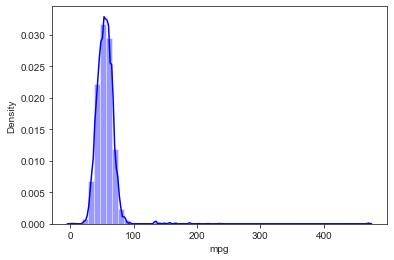

In [18]:
sn.distplot(vehicle_prices.mpg, color='blue')

<AxesSubplot:xlabel='engineSize', ylabel='Density'>

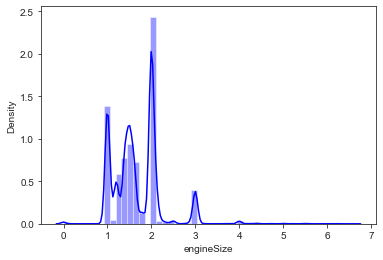

In [19]:
sn.distplot(vehicle_prices.engineSize, color='blue')

También hay que normalizar la variable

# Imputation

In [20]:
tax = vehicle_prices['tax'].mean()
tax =math.floor(tax)
mpg = vehicle_prices['mpg'].mean()
mpg = math.floor(mpg)
print("Media de tax" , tax , "y la media de media de mpg", mpg)

Media de tax 120 y la media de media de mpg 55


In [21]:
vehicle_prices['tax'].fillna(tax, inplace = True)

In [22]:
vehicle_prices['mpg'].fillna(mpg, inplace = True)

In [23]:
filtered_vehicles = vehicle_prices[vehicle_prices['year'] > 2012]  

In [24]:
filtered_vehicles['year'].unique()

array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020, 2060], dtype=int64)

In [25]:
filtered_vehicles=filtered_vehicles[filtered_vehicles['year']!=2060]

In [26]:

filtered_vehicles['year'].unique()


array([2018, 2019, 2017, 2016, 2013, 2014, 2015, 2020], dtype=int64)

In [27]:
filtered_vehicles.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145.0,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145.0,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30.0,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145.0,43.5,1.4,vauxhall


Ahora ya tenemos listos nuestros datos numéricos

#### Split de data

In [28]:
df_inicial = filtered_vehicles.sample(frac=1)

In [29]:
df_inicial.head(1)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
106617,GL Class,2016,16999,Automatic,34586,Diesel,125.0,56.6,2.1,mercedes


In [30]:
y = df_inicial.price
df_inicial = df_inicial.drop('price', axis = 1)


In [31]:
y.head()

106617    16999
19217     22512
103076    23500
18496     27710
15735     13111
Name: price, dtype: int64

In [32]:
print(y.shape,df_inicial.shape)

(105892,) (105892, 9)


In [33]:
df_inicial.dtypes

model            object
year              int64
transmission     object
mileage           int64
fuelType         object
tax             float64
mpg             float64
engineSize      float64
make             object
dtype: object

In [34]:
#df_inicial['year']=df_inicial['year']#.astype(str)
df_inicial['mileage']=df_inicial['mileage'].astype(float)

In [35]:
print(df_inicial.dtypes)

model            object
year              int64
transmission     object
mileage         float64
fuelType         object
tax             float64
mpg             float64
engineSize      float64
make             object
dtype: object


In [36]:
print(y.dtypes)

int64


Ahora tenemos que separar la data en numérica y categórica

In [37]:
num_features1 = df_inicial.select_dtypes(include='number').columns
cat_features1 = df_inicial.select_dtypes(exclude='number').columns

print('Numerical Features:')
for f in num_features1:
    print(f,end=', ')

print('\n\nCategorical Features:')
for f in cat_features1:
    print(f,end=', ')

Numerical Features:
year, mileage, tax, mpg, engineSize, 

Categorical Features:
model, transmission, fuelType, make, 

In [38]:
car_numeric = df_inicial[num_features1]
car_categorical=df_inicial[cat_features1]

In [39]:
print(car_numeric.head(2),'\n \n', car_numeric.shape)

        year  mileage    tax   mpg  engineSize
106617  2016  34586.0  125.0  56.6         2.1
19217   2018  14100.0  145.0  60.1         2.0 
 
 (105892, 5)


In [40]:
print(car_categorical.head(2),'\n \n', car_categorical.shape)

           model transmission fuelType      make
106617  GL Class    Automatic   Diesel  mercedes
19217         X1    Semi-Auto   Diesel       bmw 
 
 (105892, 4)


In [41]:
car_categorical.head(1)

,model,transmission,fuelType,make
106617,GL Class,Automatic,Diesel,mercedes


### Estandarización de la data numérica
* Usando StandardScaler


In [42]:
scaler = StandardScaler()

In [43]:
X_stand = scaler.fit_transform(car_numeric)

In [44]:
numeric_df = DataFrame(X_stand)

In [45]:
final_numeric = numeric_df.rename(columns={0:'year',1:'mileage',2:'tax',3:'mpg',4:'enginesize'},inplace=False)
final_numeric.head()

,year,mileage,tax,mpg,enginesize
0,-0.764111,0.676703,0.103928,0.082664,0.798697
1,0.418866,-0.398080,0.448351,0.308574,0.618359
2,1.010354,-0.756883,0.534457,-0.130337,-0.644010
3,1.010354,-0.637055,0.448351,-0.194883,0.618359
4,-1.355600,0.085640,-1.704296,0.986304,0.618359


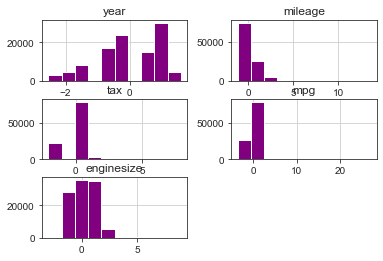

In [46]:
final_numeric.hist(color='purple')
plt.show()

### One hot encoding de la data categórica
* Usando one hot encoder


In [47]:
car_categorical=car_categorical.drop('model',axis=1)

In [48]:
car_categorical

,transmission,fuelType,make
106617,Automatic,Diesel,mercedes
19217,Semi-Auto,Diesel,bmw
103076,Semi-Auto,Petrol,mercedes
18496,Semi-Auto,Diesel,bmw
15735,Manual,Diesel,bmw
...,...,...,...
16084,Semi-Auto,Diesel,bmw
9853,Manual,Diesel,vauxhall
105197,Automatic,Diesel,mercedes
84988,Automatic,Diesel,ford


Aquí es donde le doy drop a la variale *model* para ya no hacer mi análisis con esta

In [49]:
encoder = OneHotEncoder()
cat_encoded= DataFrame(encoder.fit_transform(car_categorical).toarray())

In [50]:
cat_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105887,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105888,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105890,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combinando datasets

In [54]:
categorical= cat_encoded.to_numpy()
numeric =final_numeric.to_numpy()


In [55]:
numeric=DataFrame(numeric)
numeric = numeric.rename(columns={0:'year',1:'mileage',2:'tax',3:'mpg',4:'enginesize'},inplace=False)


In [56]:
numeric.shape

(105892, 5)

In [57]:
categorical=DataFrame(categorical)

In [58]:
categorical.shape

(105892, 18)

In [59]:
df_final = pd.concat([numeric.reset_index(drop=True),categorical.reset_index(drop=True)], axis=1)

In [60]:
df_final.describe()

,year,mileage,tax,mpg,enginesize,0,1,2,3,4,...,8,9,10,11,12,13,14,15,16,17
count,1.058920e+05,1.058920e+05,1.058920e+05,1.058920e+05,1.058920e+05,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,...,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000,105892.000000
mean,5.369304e-14,2.623637e-17,-2.549827e-18,7.619956e-16,-4.016648e-16,0.203226,0.561893,0.000085,0.234796,0.415990,...,0.551298,0.098336,0.098676,0.214681,0.044989,0.157462,0.058588,0.061629,0.125250,0.140388
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.402401,0.496157,0.009219,0.423873,0.492894,...,0.497364,0.297770,0.298228,0.410603,0.207281,0.364238,0.234853,0.240481,0.331004,0.347391
min,-2.538577e+00,-1.137774e+00,-2.048719e+00,-3.551263e+00,-2.988410e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.641111e-01,-7.579327e-01,1.782177e-02,-5.305210e-01,-8.243487e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.726227e-01,-2.627749e-01,4.483511e-01,-2.060952e-02,-1.029948e-01,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.010354e+00,4.885659e-01,4.483511e-01,3.924833e-01,6.183590e-01,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.601843e+00,1.349971e+01,7.939562e+00,2.681752e+01,8.913928e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
car_predictor_final_dataset = DataFrame(np.hstack((categorical,numeric)))

In [62]:
car_predictor_final_dataset.head(1)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.764111,0.676703,0.103928,0.082664,0.798697


In [63]:
numeric.head(1)

,year,mileage,tax,mpg,enginesize
0,-0.764111,0.676703,0.103928,0.082664,0.798697


In [64]:
car_predictor_final_dataset=car_predictor_final_dataset.rename(columns={18:'year',19:'mileage',20:'tax',21:'mpg',22:'enginesize'})

#### Training and test dataset

In [65]:
X_train,X_test,y_train,y_test = train_test_split(df_final,y, test_size=0.3,random_state=42,shuffle=True)

In [66]:
print(X_train.shape,y_train.shape)

(74124, 23) (74124,)


In [67]:
print(X_test.shape,y_test.shape)

(31768, 23) (31768,)


### Regresión lineal múltiple

In [68]:
linear_r= linear_model.LinearRegression()

In [69]:
linear_r.fit(X_train,y_train)

LinearRegression()

In [70]:
y_predicted_lr = linear_r.predict(X_test)

### Decision Tree


Vamos a utilizar un decision Tree para evaluar este modelo, con el hiperparámetro que vamos a jugar es con el **max_depth** que representa la profundiad del árbol, al estar haciendo el modelo con variables categóricas en OH, lo recomendable es no sobrepasar 10 de profundidad
* Podemos revisar la documentación sobre los parámetros en el siguiente link *https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html*


In [71]:
DT = DecisionTreeClassifier(max_depth=3)

In [72]:
X_train.shape


(74124, 23)

In [73]:
DT=DT.fit(X_train,y_train)

In [74]:
y_pred = DT.predict(X_test)

In [75]:
pd.DataFrame({'Actual': y_test,'Predictions': y_pred})

,Actual,Predictions
40749,6995,9995
87617,16750,9995
5823,5991,6995
49103,36990,19995
35397,29990,26990
...,...,...
44251,13500,9995
36781,6822,9995
89614,22490,19995
6759,8691,6995


### Haciendo un árbol más profundo

In [76]:
DT2 = DecisionTreeClassifier(max_depth=5)

In [77]:
DT2=DT2.fit(X_train,y_train)

In [78]:
y_pred2 = DT2.predict(X_test)

In [107]:
    pd.DataFrame({'Actual': y_test,'Predictions': y_pred})

,Actual,Predictions
22649,11750,19000
68258,9750,9995
34257,9299,9995
81805,14998,9995
99565,15991,9995
...,...,...
86970,14290,19000
83207,25499,19000
101891,23949,19995
75105,7995,9995


In [79]:
DT3 = DecisionTreeClassifier(max_depth=7)
DT3=DT3.fit(X_train,y_train)
y_pred3 = DT3.predict(X_test)

In [80]:
DT4 = DecisionTreeClassifier(max_depth=9,splitter='best')
DT4=DT4.fit(X_train,y_train)
y_pred4 = DT4.predict(X_test)



### AdaBoost Regresion

* Muchas Rondas de entrenamiento
* Weighted group voting

Nos podemos referir a la documentación sobre los parámetros en el siguiente link :* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html *

In [81]:
from sklearn.ensemble import AdaBoostRegressor

In [86]:
adaboost_reg1 = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss='linear')

In [87]:
adaboost1 = adaboost_reg1.fit(X_train, y_train)

In [94]:
y_ada_pred1 = adaboost1.predict(X_test)

In [96]:
adaboost_reg2 = AdaBoostRegressor(n_estimators=50, learning_rate=1.5, loss='linear')
adaboost2 = adaboost_reg2.fit(X_train, y_train)
y_ada_pred2 = adaboost2.predict(X_test)

### Gradient  Boosting Regressor

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

Nos podemos referir a la documentación sobre los parámetros en el siguiente link: *https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html*

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

In [111]:
reg = GradientBoostingRegressor(learning_rate=0.1,n_estimators=150)
reg1 = reg.fit(X_train, y_train)
#GradientBoostingRegressor(random_state=0)

y_pred_grad1 = reg1.predict(X_test) 

In [113]:
regy = GradientBoostingRegressor(learning_rate=0.1,n_estimators=300)
reg2 = regy.fit(X_train, y_train)
#GradientBoostingRegressor(random_state=0)

y_pred_grad2 = reg2.predict(X_test) 

In [119]:
regyy = GradientBoostingRegressor(learning_rate=0.1,n_estimators=450,random_state=42,max_depth=5)
reg3 = regyy.fit(X_train, y_train)
#GradientBoostingRegressor(random_state=0)

y_pred_grad3 = reg3.predict(X_test) 

In [121]:
regyyy = GradientBoostingRegressor(learning_rate=0.1,n_estimators=450,random_state=42,max_depth=8)
reg4 = regyyy.fit(X_train, y_train)
#GradientBoostingRegressor(random_state=0)

y_pred_grad4 = reg4.predict(X_test) 

### Evaluando el performance de los modelos

Para este proyecto el requerimiento es evaluar el desempeño del modelo utilizando el *Mean Absolute Error*

El MAE mide el promedio de la magnitud de los errores en un set de predicciones sin considerar su dirección. Es el promedio de la muestra del test de todas las diferencias absolutas entre la predicción y la observación

In [90]:
from sklearn.metrics import mean_absolute_error

Decision Tree MAE

In [91]:
print("Decision Tree profundidad 3:")
print(mean_absolute_error(y_test,y_pred))
print("Decision Tree profundidad 5:")
print(mean_absolute_error(y_test,y_pred2))
print("Decision Tree profundidad 7:")
print(mean_absolute_error(y_test,y_pred3))
print("Decision Tree profundidad 9:")
print(mean_absolute_error(y_test,y_pred4))




Decision Tree profundidad 3:
3754.9340846134473
Decision Tree profundidad 5:
3547.6354822462854
Decision Tree profundidad 7:
3084.8679803575924
Decision Tree profundidad 9:
2675.6354507680685


A pesar que intentamos 4 profundidades distintas con los decision tree, no obtengo un resultado con el que me conforme.

AdaBoost Regression MAE

In [97]:
print("AdaBoost Regression:")
print(mean_absolute_error(y_test,y_ada_pred1 ))
print("AdaBoost Regression con 50 n_estimators:")
print(mean_absolute_error(y_test,y_ada_pred2 ))



AdaBoost Regression:
8764.728680915008
AdaBoost Regression con 50 n_estimators:
7900.946702382564


Gradient boosting Regressor

In [122]:
print("Gradient boosting  Regression:")
print(mean_absolute_error(y_test,y_pred_grad1))

print("Gradient boosting  Regression:")
print(mean_absolute_error(y_test,y_pred_grad2))

print("Gradient boosting  Regression 450 n estimators:")
print(mean_absolute_error(y_test,y_pred_grad3))

print("Gradient boosting  Regression 450 n estimators , max_depth =8:")
print(mean_absolute_error(y_test,y_pred_grad4))




Gradient boosting  Regression:
2021.4829846599653
Gradient boosting  Regression:
1866.381740450002
Gradient boosting  Regression 450 n estimators:
1493.0771364039956
Gradient boosting  Regression 450 n estimators , max_depth =8:
1320.560855554938


Linear Regression

In [127]:
print("Linear Regression")
print(mean_absolute_error(y_test,y_predicted_lr))


Linear Regression
2876.8009632334424


### Conclusiones

El Algoritmo con menor MAE fue el **Gradient Boosting Regressor** con los hiperparámetros de 450 estimadores, un random state de 43, un learning rate de 0.1 y un max depth de 8.

Explicación de cada modelo:

* Decision Tree: Este modelo obtuvo el segundo lugar con un MAE de 2675 teniendo un max depth de 9. Para este tipo de dataset la recomendación es no sobrepasar la profundidad de 10 ya que puede caer en overfitting, esto es una desventaja de este tipo de algoritmo.

* AdaBoost: Este modelo obtuvo el cuarto lugar con un MAE de 7900, lo cual es bastante alto y por eso solo hice 2 iteraciones de este modelo. Este modelo va iteranto sobre el performance actual que tiene y son computados iterativamente.

* Gradient Boosting Regressor: Este modelo obtuvo el primer lugar con un mae de 1320, y aunque este algoritmo es bastante similar al AdaBoost, este nos da un mucho mejor performance porque es un algoritmo más robusto que Adaboost porque se le pueden modificar más hiperparámetros

* Linear Regression: Este fue modelo obtuvo el tercer lugar con un MAE de 2876, lo cual es bastante alejado todavía.